In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
class Config:
    
    def __init__(self):
        self.ROOT_DATA_DIR = "FashionMNIST"
        self.EPOCH = 10
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.01
        self.IMAGE_SIZE = (28, 28)
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"this notebook is using device : {self.DEVICE}")
        self.SEED = 2022
        
config = Config()

this notebook is using device : cpu


In [3]:
train_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

In [6]:
len(train_data.data)

60000

torchvision.datasets.mnist.FashionMNIST

In [6]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
label_map = {v:k for k,v in train_data.class_to_idx.items()}

In [9]:
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Visualize one of the sample

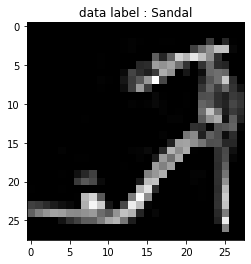

In [10]:
def view_sample_img(data, idx, label_map):
    plt.imshow(train_data.data[idx], cmap="gray")
    plt.title(f"data label : {label_map[data.targets[idx].item()]}")
    
view_sample_img(train_data, 8, label_map)

In [11]:
train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = config.BATCH_SIZE,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = config.BATCH_SIZE,
    shuffle = False
)

In [12]:
for images, label in test_data_loader:
    print(images.shape)
    print(label.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [13]:
class CNN(nn.Module):
    
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
        
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = F.relu(x)
        x = self.FC_02(x)
        x = F.relu(x)
        x = self.FC_03(x)
        x = F.relu(x)
        return x

In [1]:
model = CNN(1, 10)
model.to(config.DEVICE)
print(model)

NameError: name 'CNN' is not defined

In [15]:
model.conv_pool_02

Sequential(
  (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [18]:
model.parameters()

<generator object Module.parameters at 0x00000210189222C8>

## Count the no of trainable parameters

In [17]:
from pyparsing.core import ParseAction

def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = {"trainable": 0, "non_trainable": 0}
    for name, parameters in model.named_parameters():
        # numel() returns the total no. of elements in the tensor
        param = parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"] += param
            continue
        model_params["Modules"].append(name)
        model_params["Parameters"].append(name)
        total["trainable"] += param

    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total parameters: {total}")
    return df

count_params(model) 

,Modules,Parameters
0,conv_pool_01.0.weight,conv_pool_01.0.weight
1,conv_pool_01.0.bias,conv_pool_01.0.bias
2,conv_pool_02.0.weight,conv_pool_02.0.weight
3,conv_pool_02.0.bias,conv_pool_02.0.bias
4,FC_01.weight,FC_01.weight
5,FC_01.bias,FC_01.bias
6,FC_02.weight,FC_02.weight
7,FC_02.bias,FC_02.bias
8,FC_03.weight,FC_03.weight
9,FC_03.bias,FC_03.bias


## Training loop

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [20]:
len(train_data_loader) # steps per epoch

1875

In [22]:
for epochs in range(config.EPOCH):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epochs + 1} / {config.EPOCH}")
            
            # Put images on device
            images = images.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad() # sets all gradients to zero
            loss.backward() # calculate gradient of each weight
            optimizer.step() # updates the weights
            
            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 10 / 10: 100%|███████████████████████████████████████████████████| 1875/1875 [00:57<00:00, 32.51it/s, loss=0.503]


## Save our Model

In [23]:
os.makedirs("model_dir", exist_ok=True)
model_file_path = os.path.join("model_dir", "CNN_model.pth")
torch.save(model, model_file_path)

## Evaluate Model

In [24]:
loaded_model = torch.load(model_file_path)

In [25]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        images = data[0].to(config.DEVICE)
        labels = data[1].to(config.DEVICE)
        
        y_pred = model(images)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, labels.cpu().numpy()))

## Prediction of our model

In [26]:
cm = confusion_matrix(target, pred)

In [27]:
cm

array([[4630,    0,   29,  208,   12,    4, 1103,    1,   12,    1],
       [5772,    0,    1,  146,    5,    3,   66,    1,    6,    0],
       [ 150,    0, 4439,   44,  704,    2,  645,    1,   15,    0],
       [ 149,    0,    9, 5369,  311,    0,  160,    0,    1,    1],
       [  26,    0,  536,  145, 4841,    0,  450,    0,    2,    0],
       [   2,    0,    0,    1,    0, 5565,   77,  272,    2,   81],
       [ 751,    0,  353,  159,  469,    2, 4226,    1,   38,    1],
       [   0,    0,    0,    0,    1,   96,   27, 5742,    0,  134],
       [  25,    0,   18,   24,   33,    7,  124,   11, 5758,    0],
       [   0,    0,    0,    0,    0,   16,    6,  240,    1, 5737]],
      dtype=int64)

In [28]:
def predict(data, model, label_map, device, idx = 0):
    images, labels = data
    img = images[idx]
    label = labels[idx]
    
    plt.imshow(img.squeeze(), cmap="gray")
    logit = model(img.unsqueeze(dim=1).to(device))
    pred_prob = F.softmax(logit, dim=1)
    argmax = torch.argmax(pred_prob).item()
    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]
    plt.title(f"actual : {actual_label} | predicted : {predicted_label}")
    return predicted_label, actual_label

('Dress', 'T-shirt/top')

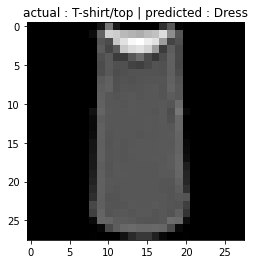

In [36]:
data = next(iter(test_data_loader))
predict(data, model, label_map, config.DEVICE, idx=2)